In [32]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

In [33]:
data_one = pd.read_csv("data/2000to2012.csv")
data_two = pd.read_csv("data/2012to2014.csv")
data_three = pd.read_csv("data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/jan2017upwards.csv")

data_one.drop(columns=["block","street_name"])
data_two.drop(columns=["block","street_name"])
data_three.drop(columns=["block","street_name"])
data_four.drop(columns=["block","street_name"])
combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)
sorted_combined_data = combined_data.sort_values(by='month', ascending=True)
sorted_combined_data['remaining_lease'].fillna('NULL', inplace=True)

sorted_combined_data


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NULL
1588,2000-01,QUEENSTOWN,3 ROOM,158,MEI LING ST,04 TO 06,66.0,Improved,1970,145000.0,NULL
1589,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,16 TO 18,72.0,Improved,1970,208000.0,NULL
1590,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,04 TO 06,72.0,Improved,1970,186000.0,NULL
1591,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,01 TO 03,72.0,Improved,1970,182000.0,NULL
...,...,...,...,...,...,...,...,...,...,...,...
633288,2024-03,HOUGANG,4 ROOM,448,HOUGANG AVE 10,01 TO 03,105.0,Model A,1990,538888.0,65 years 02 months
633289,2024-03,HOUGANG,4 ROOM,709,HOUGANG AVE 2,10 TO 12,91.0,New Generation,1985,538000.0,60 years 05 months
633290,2024-03,HOUGANG,4 ROOM,17,HOUGANG AVE 3,07 TO 09,98.0,New Generation,1978,538000.0,53 years 03 months
633276,2024-03,HOUGANG,4 ROOM,996C,BUANGKOK CRES,04 TO 06,92.0,Model A,2019,573000.0,94 years 07 months


In [34]:
CPIData = pd.read_csv('data\PercentChangeInConsumerPriceIndexCPIOverPreviousPeriod2019AsBaseYearMonthly.csv', header=None)
datetoextract = CPIData.iloc[0]
indextoextract = CPIData.iloc[67]
data = {'Period': datetoextract, 'CPIvalue': indextoextract}
AccomsCPI = pd.DataFrame(data)
AccomsCPI = AccomsCPI.drop(AccomsCPI.index[0])

AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')
AccomsCPI = AccomsCPI.sort_values(['Year', 'Date'], ascending=[False, False])
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2000-01-01']
AccomsCPI = AccomsCPI.drop(['Year', 'Month', 'Date'], axis=1)
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = 0
AccomsCPI = AccomsCPI.reset_index(drop=True)
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b')
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)
AccomsCPI.dtypes

Period       object
CPIvalue    float64
dtype: object

In [35]:
# Initial setting of AdjustmentValue
AccomsCPI['AdjustmentValue'] = 1

# Loop to calculate AdjustmentValue
for idx, cpi in enumerate(AccomsCPI['CPIvalue']):
    if idx != 0:
        AccomsCPI.loc[idx, 'AdjustmentValue'] = AccomsCPI.loc[idx - 1, 'AdjustmentValue'] * (1 + (AccomsCPI.loc[idx - 1, 'CPIvalue'] / 100))

# Corrected datetime conversion
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y-%m')

# Converting to Period type
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')

# Converting Period to string
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)

# Printing the DataFrame to check the results
print(AccomsCPI)

      Period  CPIvalue  AdjustmentValue
0    2024-01      -2.7         1.000000
1    2023-12       0.2         0.973000
2    2023-11       1.9         0.974946
3    2023-10      -1.4         0.993470
4    2023-09       0.3         0.979561
..       ...       ...              ...
284  2000-05       0.0         1.450914
285  2000-04       0.0         1.450914
286  2000-03       0.0         1.450914
287  2000-02       0.0         1.450914
288  2000-01       0.0         1.450914

[289 rows x 3 columns]


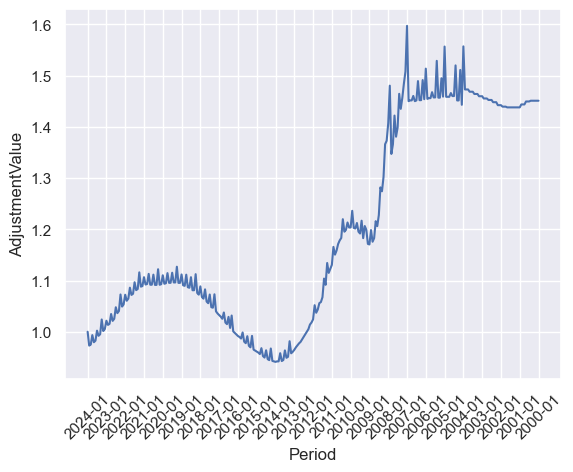

In [36]:
ax = sb.lineplot(data=AccomsCPI, x='Period', y='AdjustmentValue' )
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 


plt.show()

In [37]:
#to arrange adjust the saleprice to today's cost
merged_data = pd.merge(sorted_combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')
merged_data['AdjustmentValue'].fillna(1, inplace=True)
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']
merged_data.drop(['Period', 'CPIvalue'], axis=1, inplace=True)

#changing "x" years and "y" months into x+(y/12) years ---> eg 4years 6 months = 4.5years 
merged_data['years'] = merged_data['remaining_lease'].str.extract(r'(\d+) years').astype(float)
merged_data['months'] = merged_data['remaining_lease'].str.extract(r'(\d+) months').astype(float)
merged_data['remaining_lease'] = merged_data['years'] + merged_data['months'] / 12
merged_data = merged_data.drop(['years', 'months'], axis=1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2
merged_data = merged_data.drop(['lower_storey', 'upper_storey','storey_range','block','street_name','resale_price','AdjustmentValue'], axis=1)

#fill na for remaining lease
merged_data['remaining_lease'].fillna(np.nan, inplace=True)

merged_data.dtypes

month                     object
town                      object
flat_type                 object
floor_area_sqm           float64
flat_model                object
lease_commence_date        int64
remaining_lease          float64
resale_price_adjusted    float64
average_storey           float64
dtype: object

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6144291610822222
Mean Squared Error (MSE): 12171037222.91533

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6149428407899626
Mean Squared Error (MSE): 11984700806.214605



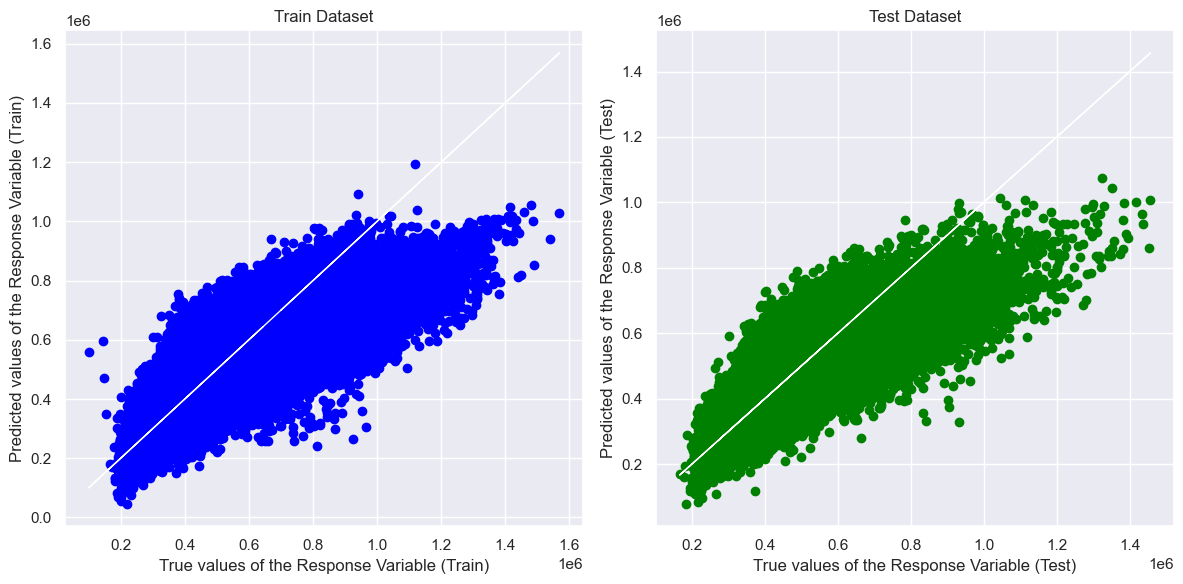

In [38]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

target = pd.DataFrame(merged_data[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted']])

# Drop NaN values from both features and target variable
target.dropna(subset=['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted'], inplace=True)
X = target[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey']]
y = target['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [39]:
merged_data.corr()


,floor_area_sqm,lease_commence_date,remaining_lease,resale_price_adjusted,average_storey
floor_area_sqm,1.000000,0.363814,0.123232,0.658493,0.045083
lease_commence_date,0.363814,1.000000,0.989363,0.482131,0.214072
remaining_lease,0.123232,0.989363,1.000000,0.333760,0.275259
resale_price_adjusted,0.658493,0.482131,0.333760,1.000000,0.318237
average_storey,0.045083,0.214072,0.275259,0.318237,1.000000


<AxesSubplot:>

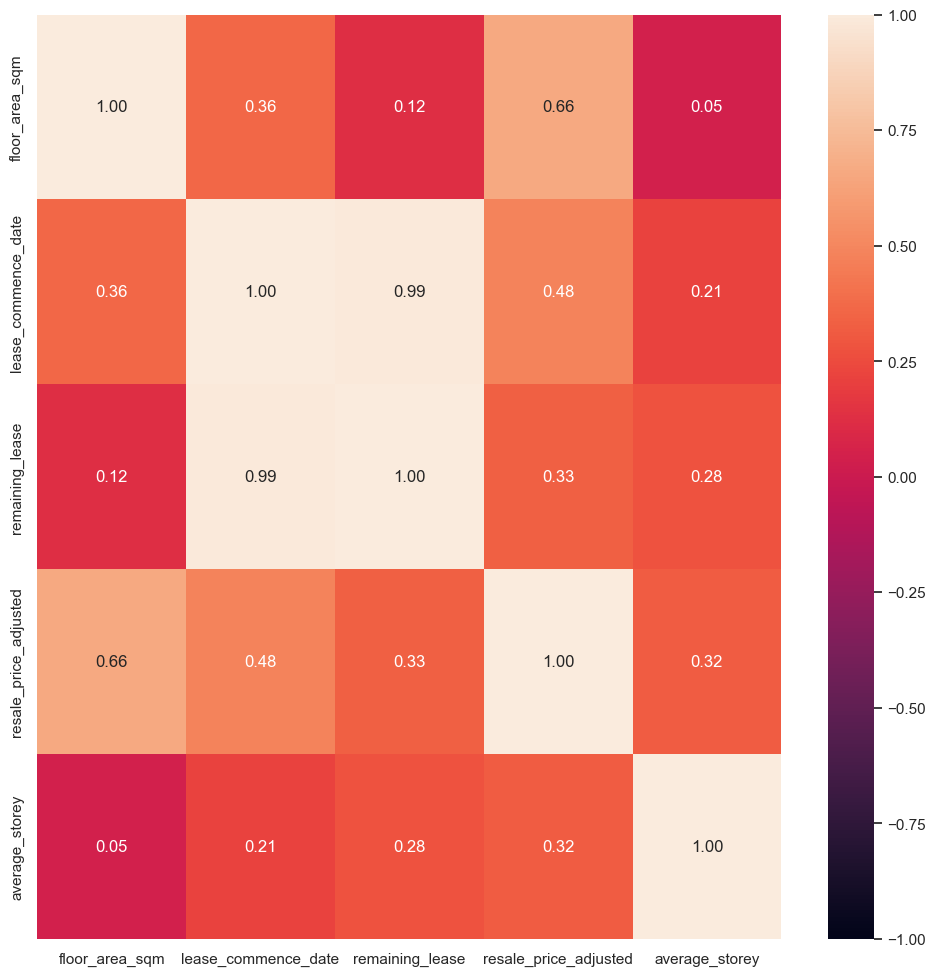

In [40]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(merged_data.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")


In [41]:
merged_data.dtypes

month                     object
town                      object
flat_type                 object
floor_area_sqm           float64
flat_model                object
lease_commence_date        int64
remaining_lease          float64
resale_price_adjusted    float64
average_storey           float64
dtype: object

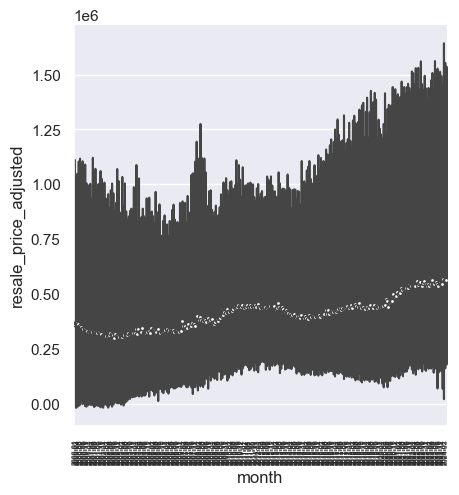

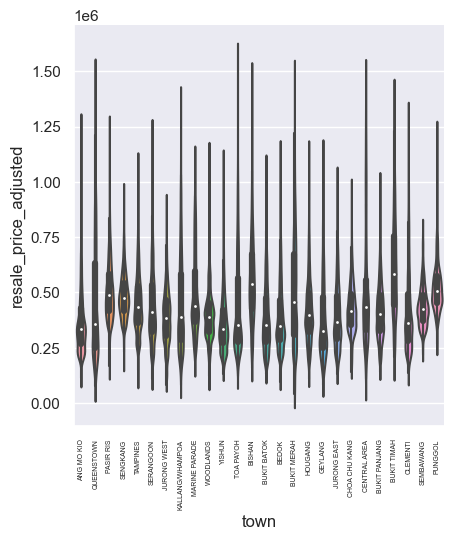

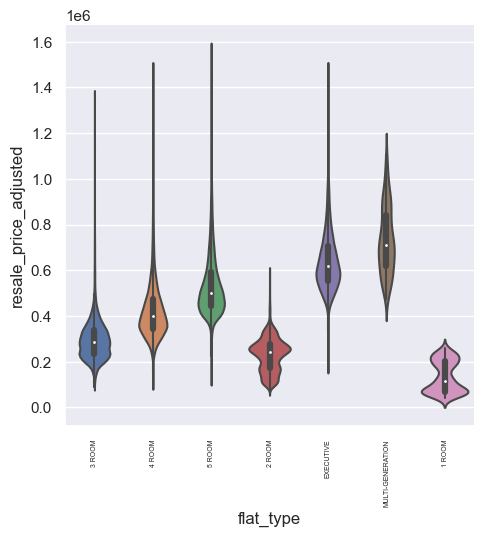

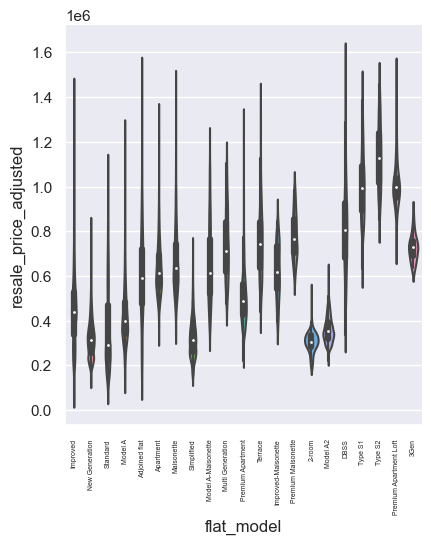

In [42]:
categoricaldata = pd.DataFrame(merged_data[['month', 'town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['month', 'town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'violin')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


In [43]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  634002 non-null  object 
 1   town                   634002 non-null  object 
 2   flat_type              634002 non-null  object 
 3   floor_area_sqm         634002 non-null  float64
 4   flat_model             634002 non-null  object 
 5   lease_commence_date    634002 non-null  int64  
 6   remaining_lease        146368 non-null  float64
 7   resale_price_adjusted  634002 non-null  float64
 8   average_storey         634002 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 48.4+ MB
